## We apply `scipy.ndimage.median_filter` and `scipy.ndimage.gaussian_filter` with Multiple passes

In [3]:
%matplotlib inline

import sys
import datacube
from datacube.utils.cog import write_cog

from skimage import restoration
from scipy import ndimage

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal

sys.path.append('../Scripts')
from deafrica_datahandling import wofs_fuser

In [4]:
dc = datacube.Datacube(app='scipy-gaussian_DEM')

In [5]:
# Define the central point of the area of interest
lat, lon = -19.85, 34.70

# buffer will define the upper and lower boundary from the central point
buffer = 0.1   

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

In [6]:
# Create a query
dem30_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-30, 30)
}

#load elevation
elevation_array30 = dc.load(product ='srtm', **dem30_query)
#elevation_array30

In [7]:
#convert to an dataArray (rather than Dataset) and select single time-slice
dem30 = elevation_array30[['elevation']].isel(time=0).to_array()

In [8]:
dem30

<xarray.DataArray (variable: 1, y: 746, x: 706)>
array([[[8, 8, 8, ..., 6, 6, 7],
        [7, 7, 7, ..., 7, 6, 7],
        [6, 7, 7, ..., 8, 8, 7],
        ...,
        [5, 4, 5, ..., 0, 0, 0],
        [5, 5, 6, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2019-09-09
  * y            (y) float64 7.816e+06 7.816e+06 ... 7.793e+06 7.793e+06
  * x            (x) float64 6.675e+05 6.675e+05 ... 6.886e+05 6.886e+05
    spatial_ref  int32 2736
  * variable     (variable) <U9 'elevation'
Attributes:
    crs:           EPSG:2736
    grid_mapping:  spatial_ref

**a) We apply a `median_filter()` to resolve local outliers**

In [9]:
# does 7 mean an 7*7?
demMF = ndimage.median_filter(dem30.squeeze(), size=7, mode='mirror')

In [10]:
demMF

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       ...,
       [6, 5, 5, ..., 0, 0, 0],
       [6, 5, 5, ..., 0, 0, 0],
       [6, 5, 5, ..., 0, 0, 0]], dtype=int16)

**b) The width of the `gaussian_filter` is determined implicitly by the values of `sigma` and `truncate`. `sigma=n` is the number of pixels, or the region within n number of pixel on all sides of a point which undergoes averaging (*the filter*). In effect, the width w is** `w = 2*int(truncate*sigma + 0.5) + 1`

**So** `(w - 1)/2 = int(truncate*sigma + 0.5)`. 

**For `w = 7` (*a gaussian filter with dimension 7x7 pixels or 210x210 meters*), the left side is:** `3 <= truncate*sigma + 0.5`

**If you choose `truncate = 1.25` (*overriding the default of 4*), we get** `2 <= sigma` *~ gaussian filtering needs large numbers and a sigma < 1 leads to a large degree of aliasing*

In [68]:
nu_passes = 3
sigma = 2
truncate = 1.25

In [69]:
dem = demMF
#or without the median ~
#dem = dem30.squeeze()

for i in range(nu_passes):
    dem = ndimage.gaussian_filter(dem, sigma=sigma, mode='mirror', truncate=truncate)

In [70]:
dem

array([[6, 6, 6, ..., 6, 7, 7],
       [6, 6, 6, ..., 6, 6, 7],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=int16)

In [71]:
print(dem30.size)
print(dem.size)
print('')
print(dem30.squeeze().shape)
print(dem.shape)

526676
526676

(746, 706)
(746, 706)


In [72]:
#create a DataArray object
da1 = xr.DataArray(data = dem.squeeze(),
                   coords = {'y': dem30.y, 
                             'x': dem30.x},
                             #'spatial_ref': 2736},
                   #attrs = {'crs': 'EPSG:2736'},
                   dims = ["y", "x"])

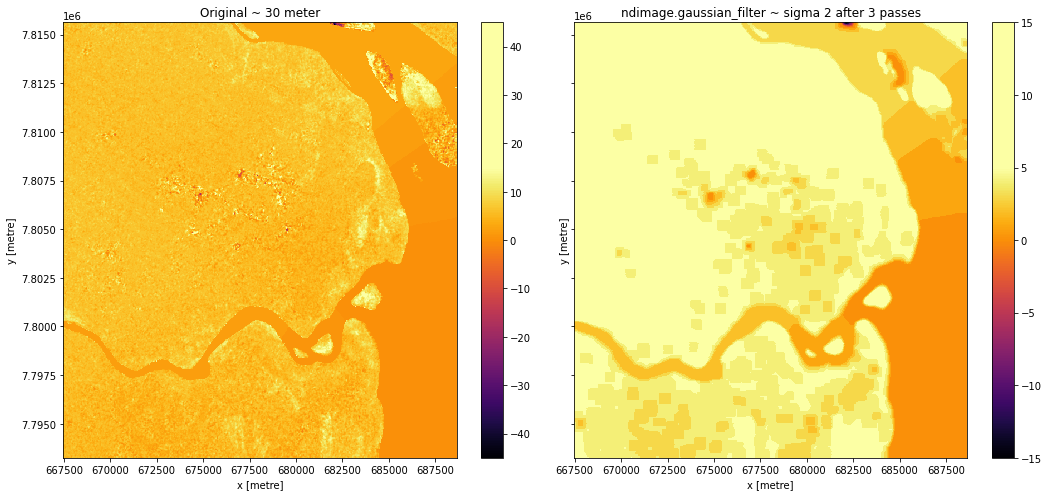

In [73]:
# Plot the elevation data
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.inferno(np.linspace(0.0, 1.5, 25))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('inferno', colors_terrain)

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(121)
dem30.plot(ax=ax1, cmap=cmap_terrain)
ax1.set_title('Original ~ 30 meter')
#plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(122, sharey=ax1)
da1.plot(ax=ax2, cmap=cmap_terrain)
ax2.set_title('ndimage.gaussian_filter ~ sigma '+str(sigma)+' after '+str(nu_passes)+' passes')
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)

plt.tight_layout() 
plt.show()

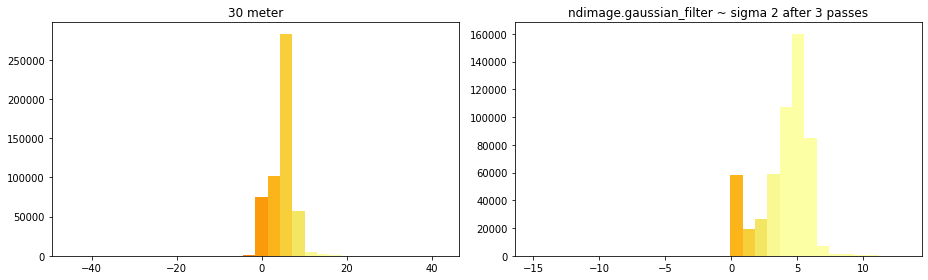

In [74]:
### Plot instance
f, ax = plt.subplots(1, 2, figsize=(13, 4))

# histogram.
n, bins, patches = dem30.squeeze().plot.hist(ax=ax[0],
                                           color="purple",
                                           bins=30)                 # feel free to change these 
ax[0].set_title('30 meter')
bin_centers = 0.8 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap_terrain(c))
    
# histogram.
n, bins2, patches = da1.plot.hist(ax=ax[1],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[1].set_title('ndimage.gaussian_filter ~ sigma '+str(sigma)+' after '+str(nu_passes)+' passes')
bin_centers2 = 0.8 * (bins2[:-1] + bins2[1:])
# scale values to interval [0,1]
col2 = bin_centers2 - min(bin_centers2)
col2 /= max(col2)
for c, p2 in zip(col2, patches):
    plt.setp(p2, 'facecolor', cmap_terrain(c))

plt.tight_layout() 
plt.show()

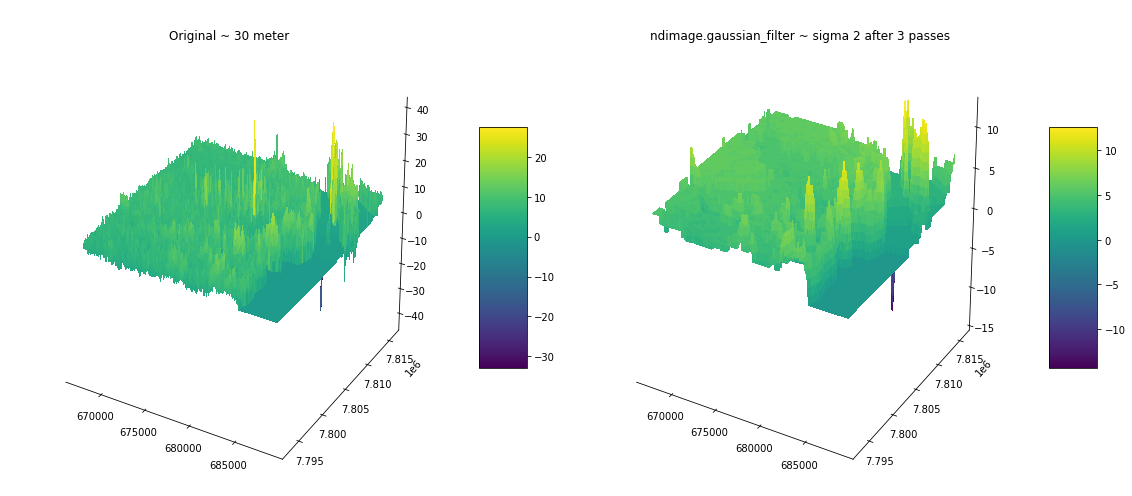

In [75]:
# set up a figure 
fig = plt.figure(figsize=(16, 7))

#transform the image
xres = elevation_array30.geobox.transform[0]
yres = elevation_array30.geobox.transform[4]
X = np.arange(dem30.geobox.transform[2], dem30.geobox.transform[2] + dem30.shape[1:][1]*xres, xres)
Y = np.arange(dem30.geobox.transform[5], dem30.geobox.transform[5] + dem30.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

#do one image
ax1 = fig.add_subplot(121,projection='3d')

# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf1 = ax1.plot_surface(X, Y, dem30.squeeze(), rstride=2, cstride=2, cmap='viridis', linewidth=0, antialiased=False)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax1.view_init(30, 300)
fig.colorbar(surf1, shrink=0.5, aspect=5)
ax1.set_title('Original ~ 30 meter')

#do another image
ax2 = fig.add_subplot(122,projection='3d')

# make the panes transparent
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax2.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf2 = ax2.plot_surface(X, Y, da1.squeeze(), rstride=2, cstride=2, cmap='viridis', linewidth=0, antialiased=False)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax2.view_init(30, 300)
fig.colorbar(surf2, shrink=0.5, aspect=5)
ax2.set_title('ndimage.gaussian_filter ~ sigma '+str(sigma)+' after '+str(nu_passes)+' passes')#+str(variable))

plt.tight_layout() 
plt.show()

### Inundation Senario

In [19]:
flood_range = 7

In [20]:
mask = {}

for k in range(flood_range):
    mask[k] = da1 <= k

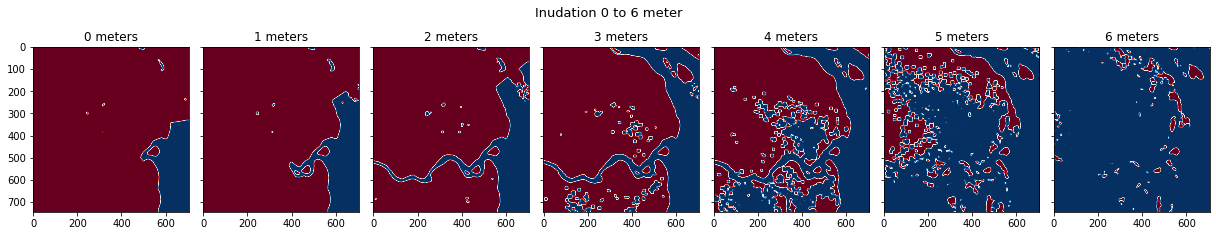

In [21]:
_, axs = plt.subplots(1, len(mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(mask, axs):
    ax.imshow(mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')
    
plt.suptitle('Inudation 0 to 6 meter', size = 13, y = 0.6)
plt.tight_layout()
plt.show()

In [22]:
# Create a query
wofs_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'time': ('2018-01-01', '2018-12-30'),
    'resolution': (-30, 30)
}

# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2_annual_summary", group_by="solar_day",
                            fuse_func=wofs_fuser, **wofs_query)

In [23]:
mask_with90 = wofls.squeeze().frequency >= 0.9
mask_with90.values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

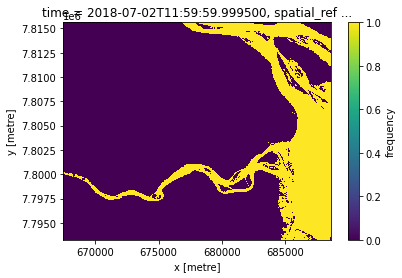

In [24]:
#plot
mask_with90.plot()

### New Inundation Senario with WOfS removed

In [25]:
new_mask = {}

for i in range(flood_range):
    new_mask[i] = mask[i].where(wofls.squeeze().frequency <= 0.9)

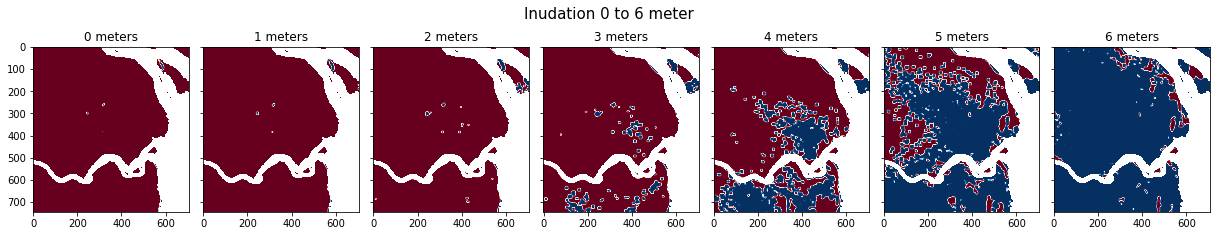

In [26]:
_, axs = plt.subplots(1, len(new_mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(new_mask, axs):
    cb = ax.imshow(new_mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')

#plt.colorbar(cb)                                                      #perhaps a colorbar would be informative - add divider?
plt.suptitle('Inudation 0 to 6 meter', size = 15, y = 0.6)
plt.tight_layout()
plt.show()

### Compare with SAR ~ Sentinel 1: Beira_March 2019

In [27]:
#dataset = gdal.Open('../Supplementary_data/WorkingFolder/Beira_19032019_flooding.tif')#, gdal.GA_ReadOnly) 
dataset = gdal.Open('../Supplementary_data/WorkingFolder/beira_un-spider2.tif')
# Note GetRasterBand() takes band no. starting from 1 not 0
#band = dataset.GetRasterBand(1)
arr = dataset.ReadAsArray()

In [138]:
import matplotlib.gridspec as gridspec

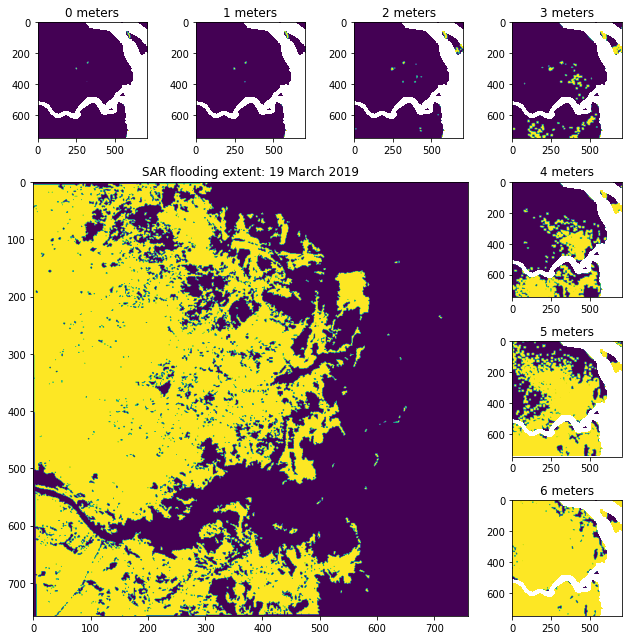

In [51]:
fig = plt.figure(figsize=(9, 9), constrained_layout=False)
a1 = plt.subplot2grid((4,4),(0,0))
a2 = plt.subplot2grid((4,4),(0,1))
a3 = plt.subplot2grid((4,4),(0,2))
a4 = plt.subplot2grid((4,4),(0,3))

a5 = plt.subplot2grid((4,4),(1,0), rowspan = 3, colspan = 3)

a6 = plt.subplot2grid((4,4),(1,3))
a7 = plt.subplot2grid((4,4),(2,3))
a8= plt.subplot2grid((4,4),(3,3))

a1.imshow(new_mask[0].squeeze())
a1.set_title('0 meters')
a2.imshow(new_mask[1].squeeze())
a2.set_title('1 meters')
a3.imshow(new_mask[2].squeeze())
a3.set_title('2 meters')
a4.imshow(new_mask[3].squeeze())
a4.set_title('3 meters')
a5.imshow(arr, zorder=1) #a1.set_title('exp')
#a5.imshow(mask_with90, cmap='Greys_r',  interpolation='nearest', zorder=2, alpha=0.3)
a5.set_title('SAR flooding extent: 19 March 2019')
a6.imshow(new_mask[4].squeeze())
a6.set_title('4 meters')
a7.imshow(new_mask[5].squeeze())
a7.set_title('5 meters')
a8.imshow(new_mask[6].squeeze())
a8.set_title('6 meters')

#plt.axes.xaxis.set_ticks([])
#plt.axes.yaxis.set_ticks([])
#plt.tick_labels('off')

plt.tight_layout()
plt.show()